# Data Science Projekt Robert Scheer

## Einleitung

In diesem Projekt werden Flugdaten amerikanischer Inlandsfluege von 2018 bis 2022 untersucht.
Das Datenset beinhaltet ueber 26 Millionen Fluege, jeweils mit Start und Zielflughafen, Airline, Flugnummer und Start- und Landeverspaetung.

*Wenn in diesem Projekt von Verspaetung geredet wird, ist ab hier die Landeverspaetung gemeint, da diese fuer Kunden bzw Passagiere ausschlaggebender ist.*

Genauer gesagt werden folgende Hypothesen ueberprueft:

1. Fluege im Winter haben haeufiger Verspaetungen.
2. Langstreckefluege haben weniger Verspaetungen als Kurzstreckenfluege.
3. Fluege mit grossen Zielflughaefen haben, falls sie Verspaetungen haben, groessere Verspaetungen als Fluege mit kleineren Zielflughaefen.

Aussderdem wird untersucht, ob die Verspaetung eines Flugs mittels eines Neuronalen Netz vorhersagbar ist.
Es wird auch untersucht, welche Merkmale ausschlaggebend sind.

## Imports

Zuerst werden die benoetigten Module importiert.
Das src Modul implementiert Methoden, die spezifisch fuer das Projekt erstellt wurden.
Damit das src Modul importiert werden kann, muss der Ordner zum path hinzugefuegt werden.

In [1]:
import sys
import os
import random

import pandas as pd
import numpy as np
import scipy.stats as stats

sys.path.append(os.path.abspath(os.path.join(os.path.abspath("."), ".."))) # Wird nach Ausfuerung zurueckgesetzt

## Laden der Daten

Hier wird der Datensatz zuerst als zip datei runtergeladen, dann exportiert und gefiltert.
Der Download betraegt ca. 4GB, es kann also eine Weile dauern, bis er fertig heruntergeladen ist.

Beim Filtern werden ueberfluessige Spalten aus den Daten geloescht, um die Groesse des Datensatzes zu reduzieren.
Dabei geht die Groesse des extrahierten Datensatzes von 9GB auf 4.5GB herunter.

In [2]:
import src.data.folders
import src.data.download
import src.data.extract
import src.data.filter
import src.data.loading

src.data.folders.dataset_folders()
src.data.download.dataset_download(auto_skip=True)
src.data.extract.dataset_extract(auto_skip=True)
src.data.filter.dataset_filter(auto_skip=True)

data = src.data.loading.load_all()

print("Deleting", data["ArrDelay"].isna().sum(), "NaN values...")
data = data.dropna(subset=["ArrDelay"])


Auto Skipping Download...
Auto Skipping extraction...
Auto Skipping filtration...
Loading full dataset...


Loaded 29193782 flights!
Deleting 846183 NaN values...


## Visualisierungen

Hier wird der Datensatz visualiert, um ein Gefuehl fuer die Daten zu bekommen.

Zufaellig ausgewaehlter Datenpunkt: 
FlightDate: 2021-07-04
Airline: Alaska Airlines Inc.
Cancelled: False
Diverted: False
CRSDepTime: 700
DepTime: 658.0
DepDelay: -2.0
ArrTime: 835.0
ArrDelay: -5.0
AirTime: 74.0
CRSElapsedTime: 100.0
ActualElapsedTime: 97.0
Distance: 550.0
DayOfWeek: 7
Operating_Airline: AS
Tail_Number: N253AK
Flight_Number_Operating_Airline: 383
OriginCityName: San Francisco, CA
OriginStateName: California
DestCityName: Portland, OR
DestStateName: Oregon
CRSArrTime: 840


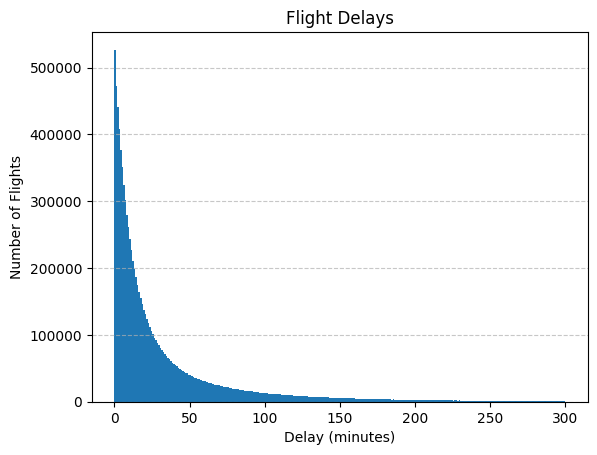

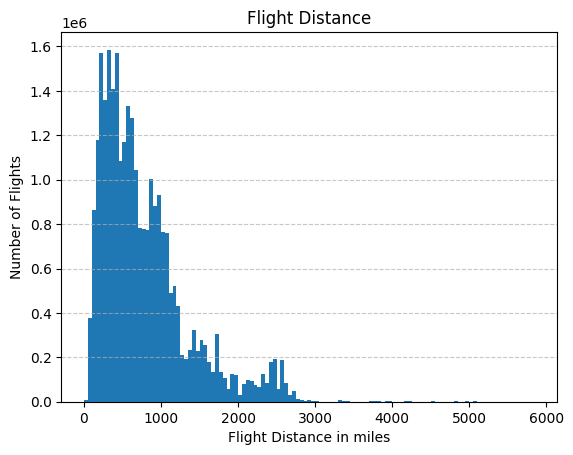

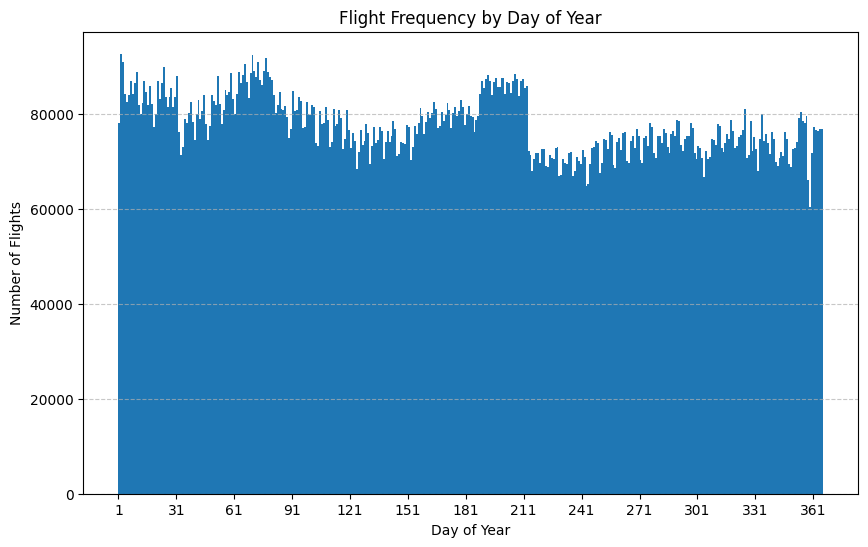

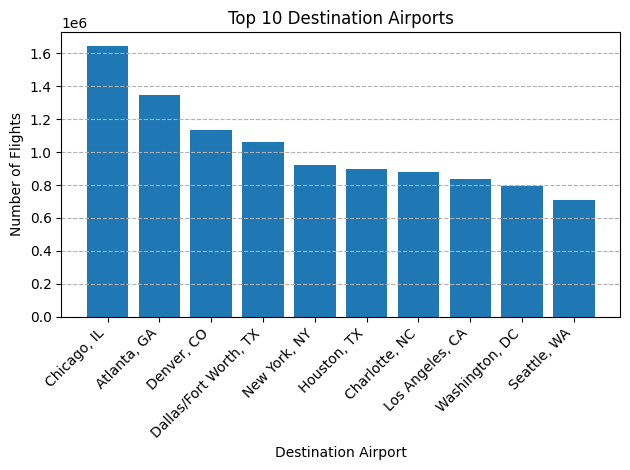

In [3]:
import src.visualization
import src.visualization.visualize


print("Zufaellig ausgewaehlter Datenpunkt: ")
[print(f"{col}: {val}") for col, val in data.iloc[random.randint(0, len(data)-1)].items()]

src.visualization.visualize.plot_delay(data)
src.visualization.visualize.plot_distance(data)
src.visualization.visualize.plot_yearly_activities(data)
src.visualization.visualize.plot_top_airports(data, 10)

Von [Wikipedia](https://en.wikipedia.org/wiki/O%27Hare_International_Airport):
> As of 2024, O'Hare (Chicaco Airport) is considered the most connected airport in the US...

Dies deutet darauf hin, dass die Daten schlüssig und zuverlässig sind.

## Hypothesentests

### Hypothese 1

Hypothese: **Fluege im Winter haben haeufiger Verspaetungen**

Als Winter werden die Monate Dezember, Januar und Februar definiert.
Die genaue Dauer der Verspaetung ist hierbei egal, als signifikante Verspaetung wird hier eine Verspaetung von mehr als 15 Minuten festgelegt.

Nullhypothese $H_0$: Es gibt keinen Unterschied in der Haeufigkeit der Verspaetungen zwischen Winter- und nicht Winter Fluegen.

Alternativhypothese $H_1$: Flüge im Winter haben häufiger Verspätungen.

In [4]:
winter_months = {12, 1, 2}

# Neue Spalte für Winter/Nicht-Winter erstellen
data["Winter"] = data["FlightDate"].apply(lambda x: pd.to_datetime(x).month in winter_months)

# Verspätung definieren
data["Delayed"] = (data["ArrDelay"] > 15).astype(int)

# Anteil verspäteter Flüge in Winter- und Nicht-Winter-Monaten
winter_delays = data[data["Winter"]]["Delayed"]
non_winter_delays = data[~data["Winter"]]["Delayed"]

# Chi-Quadrat-Test für Häufigkeiten
contingency_table = pd.crosstab(data["Winter"], data["Delayed"])
chi2_stat, p, _, _ = stats.chi2_contingency(contingency_table)

print(f"Chi-Quadrat-Wert: {chi2_stat}, p-Wert: {p}")

t_stat, p_ttest = stats.ttest_ind(winter_delays, non_winter_delays, equal_var=False)
print(f"t-Wert: {t_stat}, p-Wert: {p_ttest}")


Chi-Quadrat-Wert: 517.5690194481368, p-Wert: 1.4303300422738935e-114
t-Wert: 22.654564522022568, p-Wert: 1.264638372067096e-113


Da die p-Werte beider Tests deutlich kleiner als $0.05$ sind, kann die Nullhypothese mit Sicherheit verworfen werden.

**Dadurch ist bestaetigt, dass Fluege im Winter haeufiger Verspaetungen haben!**

### Hypothese 2

Hypothese: **Langstreckefluege haben weniger haeufig Verspaetungen als Kurzstreckenfluege.**

Als Verspaetung wird wieder jede Verspaetung ueber 15 Minuten gewertet. Ein Langstreckenflug wird als Flug mit ueber 1000 Meilen Distanz festgelegt.

Nullhypothese $H_0$: Es gibt keinen Unterschied in der Haeufigkeit der Verspaetungen zwischen Lang- und Kurzstreckenfluegen.

Alternativhypothese $H_1$: Langstreckefluege haben weniger haeufig Verspaetungen als Kurzstreckenfluege.

In [5]:
# Langstreckenflug = mehr als 1000 Meilen, Verspaetung ist schon bei Hypothese 1 definiert
data["LongHaul"] = data["Distance"] > 1000

long_haul_delays = data[data["LongHaul"]]["Delayed"]
short_haul_delays = data[~data["LongHaul"]]["Delayed"]

# Chi-Quadrat-Test für Häufigkeiten
contingency_table = pd.crosstab(data["LongHaul"], data["Delayed"])
chi2_stat, p_chi2, _, _ = stats.chi2_contingency(contingency_table)

print(f"Chi-Quadrat-Wert: {chi2_stat}, p-Wert: {p_chi2}")

# t-Test für Mittelwertvergleich
t_stat, p_ttest = stats.ttest_ind(long_haul_delays.astype(int), short_haul_delays.astype(int), equal_var=False)
print(f"t-Wert: {t_stat}, p-Wert: {p_ttest}")

Chi-Quadrat-Wert: 10616.546539419023, p-Wert: 0.0
t-Wert: 101.21928842622998, p-Wert: 0.0


Der p-Wert von $0.0$ beider Tests zeigt, dass die Nullhypothese $H_0$ verworfen werden kann.

### Hypothese 3

Hypothese: **Fluege mit grossen Zielflughaefen haben, falls sie Verspaetungen haben, groessere Verspaetungen als Fluege mit kleineren Zielflughaefen.**

Als Verspaetung wird wieder jede Verspaetung ueber 15 Minuten gewertet.

Ein grosser Flughafen ist ein Flughafen in den oberen 1% der meist besuchten Flughaefen.

Nullhypothese $H_0$: Es gibt keinen Unterschied in der Laenge der Verspaetungen zwischen grossen und kleinen Flughaefen.

Alternativhypothese $H_1$: An größeren Flughäfen gibt es größere Verspätungen, falls eine Verspätung auftritt.

In [6]:
# Flughäfen mit den höchsten Passagierzahlen (Top 1%)
airport_counts = data['DestCityName'].value_counts()
top_1_percent_airports = airport_counts[airport_counts > airport_counts.quantile(0.99)].index

data['LargeAirport'] = data['DestCityName'].isin(top_1_percent_airports)
data['Delayed'] = data['ArrDelay'] > 15
delayed_flights = data[data['Delayed']]

large_airport_delays = delayed_flights[delayed_flights['LargeAirport']]['ArrDelay']
small_airport_delays = delayed_flights[~delayed_flights['LargeAirport']]['ArrDelay']

t_stat, p_ttest = stats.ttest_ind(large_airport_delays, small_airport_delays, equal_var=False)
print(f"t-Wert: {t_stat}, p-Wert: {p_ttest}")

u_stat, p_u = stats.mannwhitneyu(large_airport_delays, small_airport_delays, alternative="greater")
print(f"Mann-Whitney-U-Wert: {u_stat}, p-Wert: {p_u}")

t-Wert: 67.21169329627793, p-Wert: 0.0
Mann-Whitney-U-Wert: 1731245843630.5, p-Wert: 0.0


Der p-Wert von $0.0$ beider Tests bedeutet, dass die Nullhypothese verworfen werden kann.

Daraus folgt, dass die Alternativhypothese wahr ist.

### Exkurs: Ueberpruefung der p-Werte

Die p-Werte von $0.0$ der letzten beiden Tests haben mich skeptisch gemacht, da ich nicht so ein deutliches Ergebnis erwartet haette.

Eine [Google-Suche](https://www.nature.com/articles/s41598-021-00199-5) deutet darauf hin, dass die p-Werte bei grossen Datensaetzen (zB einem wie der hier vorliegt) generell kleiner sind. 

Dadurch sind die Unterschiede zwar statistisch signifikant, allerdings sind die Auswirkungen in der realen Welt nicht unbedingt relevant.

Um die Auswirkungen zu berechnen, kann mit [Cohan's d](https://novustat.com/statistik-blog/cohens-d-effektstaerke-berechnen.html) die sogenannte Effektstaerke berechnet werden.

Ein $d$-Wert in $[0, 0.2]$ zeigt hierbei einen kleinen bzw. keinen Effekt, <br>
in $[0.2, 0.5]$ einen geringen Effekt, <br>
in $[0.5, 0.8]$ einen mittleren und ab $0.8$ einen grossen Effekt.

Im folgenden wird die Effektstaerke fuer alle drei Hypothesen berechnet.

In [7]:
winter_delays = data[data["Winter"]]["Delayed"]
non_winter_delays = data[~data["Winter"]]["Delayed"]
mean_winter = winter_delays.mean()
mean_non_winter = non_winter_delays.mean()
std_winter = winter_delays.std()
std_non_winter = non_winter_delays.std()
pooled_std_1 = np.sqrt((std_winter**2 + std_non_winter**2) / 2)
cohen_d_1 = (mean_winter - mean_non_winter) / pooled_std_1
print(f"Hypothese 1 - Cohen's d: {cohen_d_1:.3f}")

long_haul_delays = data[data["LongHaul"]]["Delayed"]
short_haul_delays = data[~data["LongHaul"]]["Delayed"]
mean_long = long_haul_delays.mean()
mean_short = short_haul_delays.mean()
std_long = long_haul_delays.std()
std_short = short_haul_delays.std()
pooled_std_2 = np.sqrt((std_long**2 + std_short**2) / 2)
cohen_d_2 = (mean_long - mean_short) / pooled_std_2
print(f"Hypothese 2 - Cohen's d: {cohen_d_2:.3f}")

mean_large = large_airport_delays.mean()
mean_small = small_airport_delays.mean()
std_large = large_airport_delays.std()
std_small = small_airport_delays.std()
pooled_std = np.sqrt((std_large**2 + std_small**2) / 2)
cohen_d_3 = (mean_large - mean_small) / pooled_std
print(f"Hypothese 3 - Cohen's d: {cohen_d_3:.3f}")

Hypothese 1 - Cohen's d: 0.010
Hypothese 2 - Cohen's d: 0.044
Hypothese 3 - Cohen's d: 0.086


Die d-Werte für alle drei Hypothesen sind sehr klein (unter 0.2), was darauf hinweist, dass die Unterschiede in den Verspätungen zwischen den verglichenen Gruppen praktisch nicht relevant sind.<br>Obwohl die Unterschiede statistisch signifikant sein könnten, sind sie aus praktischer Sicht vernachlässigbar.

## Neuronales Netz

Im folgenden wird ein Neuronales Netz trainiert, um aufgrund der Eckdaten die Verspaetung vorhersagen zu koennen.

Es wird pytorch statt sklearn verwendet, um das Training auf der GPU durchfuehren zu koennen. 
Auf der CPU wuerde ein Datensatz dieser Groesse sehr lange dauern zum Trainieren.

Als Merkmale wurden ausgewaehlt:
- Distanz des Flugs `Distance`
- Startflughafen Rang `DepRank` \*
- Zielflughafen Rang `DestRank` \*
- Airline Rang `AirlineRank` \*
- Tag des Jahres `DayOfYear` \*
- Wochentag `DayOfWeek`

*Merkmale, die mit einem \* versehen sind, werden noch extrahiert.*

Die vom Neuronalen Netz zu berechnende Variable ist dann die Verspaetung bei Ankunft, also `ArrDelay`.

Als Metrik wird der Mean Squared Error zwischen der geschaetzten Ankunftszeit und der tatsaechlichen Ankunftszeit gewaehlt.

Fuer die Daten werden nur die Daten aus 2021 genommen, da sonst der Datensatz zu gross ist.

In [8]:
import src.features
import src.features.build_features

data = src.data.loading.load_single(2021)

print("Deleting", data["ArrDelay"].isna().sum(), "NaN values...")
data = data.dropna(subset=["ArrDelay"])

data = src.features.build_features.build_airline_rank(data)
data = src.features.build_features.build_day_of_year(data)
data = src.features.build_features.build_dep_airport_rank(data)
data = src.features.build_features.build_dest_airport_rank(data)

Loading subset for 2021...


Loaded 6311871 flights from 2021!
Deleting 126001 NaN values...


Im folgenden wird der Dataframe zu den NN-Kompatiblen Daten gewandelt.

In [9]:
import src.data
import src.data.loading
import src.models
import src.models.network
import torch

merkmale = ["Distance", "DepRank", "DestRank", "AirlineRank", "DayOfYear", "DayOfWeek"]

x = torch.tensor(data[merkmale].values, dtype=torch.float32)
y = torch.tensor(data["ArrDelay"].values, dtype=torch.float32)

print(x.shape, y.shape)

nn_data = src.models.network.Flights_Data(x, y)

torch.Size([6185870, 6]) torch.Size([6185870])


Hier wird geschaut, ob eine Grafikkarte zur Beschleunigung verfuegbar ist. Falls ja, wird diese fuer das Trainieren und Testen des NN verwendet.
Dann werden die Daten in ein Trainings-, Validierungs- und Testsubset aufgeteilt und dann auf das Zielgeraet (CPU/GPU) verschoben.
Danach werden die DataLoader erstellt, um die Daten in Batches beim Trainieren zu Laden.

In [10]:
device = src.models.network.get_device(mute=False)

nn_data_train, nn_data_val, nn_data_test = src.models.network.split_data(nn_data)

train_features = torch.stack([x for x, _ in nn_data_train])
train_mean = train_features.mean(dim=0)
train_std = train_features.std(dim=0)

normalizer = src.models.network.Normalizer(train_mean, train_std)

print(f"Data Stats - Mean: {train_mean.mean()} ± {train_std.mean()}")

nn_data_train = src.models.network.move_and_norm_data(nn_data_train, normalizer, device)
nn_data_val = src.models.network.move_and_norm_data(nn_data_val, normalizer, device)
nn_data_test = src.models.network.move_and_norm_data(nn_data_test, normalizer, device)


train_loader = torch.utils.data.DataLoader(
    nn_data_train,
    batch_size=512,
    shuffle=True,
    num_workers=0
)
val_loader = torch.utils.data.DataLoader(
    nn_data_val,
    batch_size=512,
    shuffle=True,
    num_workers=0
)
test_loader = torch.utils.data.DataLoader(
    nn_data_test,
    batch_size=512,
    shuffle=True,
    num_workers=0
)

Using GPU: Radeon RX 7900 GRE


/home/roberto/Documents/GitHub/data-science-project/src/models/network.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.X[index], dtype=torch.float32), torch.tensor(self.y[index], dtype=torch.int64)


Data Stats - Mean: 179.59596252441406 ± 132.8374481201172


Im folgenden wird das Netz erstellt.
Das Netz besteht aus zwei hintereinander geschalteten Bloecken, um verschiedene Regularisierungsmethoden testen zu koennen.

Als Performance Metiken wurden der MeanSquaredError und der MeanAbsolute gewaehlt.

Der MSE gibt den durchschnittlichen Fehler zwischen der geschaetzten und echten Ankunftszeit an. Das Ergebnis wird quadriert, um groessere Fehler mehr zu bestrafen.

Nach dem Training wird das beste Modell abgespeichert.


In [22]:
from torch import nn

from torchmetrics import MeanAbsoluteError, R2Score

network = src.models.network.MLP(3, 3, 
             num_in=6, 
             num_out=1,
             hidden_size=512,
             skip_connections=False,
             activ=nn.GELU(),
             dropout=0.0).to(device)

optimizer = torch.optim.AdamW(network.parameters(), lr=0.0001)
loss_fn = nn.MSELoss().to(device)
acc = MeanAbsoluteError().to(device)

max_epochs = 250

best_network = None
lowest_loss = np.Inf
best_epoch = 0

for e in range(max_epochs):
    acc.reset()
    network.train()

    batch_count = 0
    print("\rTraining ...", end="")

    indices = torch.randperm(len(nn_data_train))[:256*1000]
    subset = torch.utils.data.Subset(nn_data_train, indices)
    train_loader = torch.utils.data.DataLoader(subset, batch_size=256, num_workers=0)

    for x, y in train_loader:
        x = x.float()
        y = y.float().view(-1, 1)
        y = torch.sign(y) * torch.log1p(torch.abs(y))
        optimizer.zero_grad()
        logits = network(x)
        loss = loss_fn(logits, y)
        loss.backward()
        optimizer.step()

        acc(torch.expm1(torch.abs(logits)) * torch.sign(logits), torch.expm1(torch.abs(y)) * torch.sign(y))
    
    train_acc = acc.compute()
    val_acc, val_loss = src.models.network.test_network(network, nn_data_val, 250, acc, loss_fn)

    print(f"\rEpoch {e+1:>3}/{max_epochs}: Train_acc: {train_acc:.3f}   Val_acc: {val_acc:.3f}    Val loss: {val_loss:.5f}", end="")

    if val_loss < lowest_loss:
        best_network = network.state_dict()
        lowest_loss = val_loss
        best_epoch = e
        print("    New Best", end="")
    
    print("")

print(f"Saving best model from epoch {best_epoch} with loss {lowest_loss:.2f}...")
network.load_state_dict(best_network)
torch.save(network, "../models/full_model.pth")


Epoch   1/250: Train_acc: 21.445   Val_acc: 21.456    Val loss: 6.94362    New Best
Epoch   2/250: Train_acc: 21.271   Val_acc: 20.991    Val loss: 6.88835    New Best
Epoch   3/250: Train_acc: 21.259   Val_acc: 21.061    Val loss: 6.87430    New Best
Epoch   4/250: Train_acc: 21.125   Val_acc: 20.884    Val loss: 6.80035    New Best
Epoch   5/250: Train_acc: 21.129   Val_acc: 21.334    Val loss: 6.88809
Epoch   6/250: Train_acc: 21.261   Val_acc: 20.958    Val loss: 6.80840
Epoch   7/250: Train_acc: 21.217   Val_acc: 21.133    Val loss: 6.75921    New Best
Epoch   8/250: Train_acc: 21.054   Val_acc: 21.246    Val loss: 6.81391
Epoch   9/250: Train_acc: 21.306   Val_acc: 21.247    Val loss: 6.81007
Epoch  10/250: Train_acc: 21.115   Val_acc: 20.886    Val loss: 6.83356
Epoch  11/250: Train_acc: 21.152   Val_acc: 20.886    Val loss: 6.77479
Epoch  12/250: Train_acc: 20.993   Val_acc: 21.004    Val loss: 6.75164    New Best
Epoch  13/250: Train_acc: 21.248   Val_acc: 21.295    Val loss: 

Man kann erkennen, dass die Validation Loss und Accuracy sich nicht verbessern, was auf ein Underfitting hindeutet.

Allerdings haben sich die Werte auch fuer ein sehr grosses Netz (16 Layer, 2048 Nodes pro Layer) nicht verbessert.

Die anderen Hyperparameter wurden mittels einer manuellen Gridsearch getestet. Auch hier konnten keine Verbesserungen gefunden werden.

Im folgenden wird mit dem R2 Score geprueft wie gut das Modell die Verspaetungen vorhersagt.

Der R2Score zeigt, wie gut die Vorhersagen des Netzes sind.
Ein R2Score von $\le 0$ bedeutet eine schlechtere Vorhersage als eine Mittelwert-Vorhersage, ein R2Score $>0$ eine gute, und ein R2Score von $1$ eine perfekte Vorhersage.

In [23]:
network = torch.load("../models/full_model.pth", weights_only=False)
network.eval()

r2_metric = R2Score().to(device)

r2_score, _ = src.models.network.test_network(network, nn_data_val, 10_000, r2_metric, loss_fn)

print("Model R2Score:", r2_score)

Model R2Score: tensor(0.0091, device='cuda:0')


Der R2Score zeigt, dass das Modell leider keinen Zusammenhang zwischen den Verspaetungen und den gegebenen Daten feststellen kann.

Das liegt wahrscheinlich an den gegebenen Daten, die nicht ausreichend sind, um die Verspaetung richtig vorherzusagen.

Ausschlaggebend waeren wahrscheinlich noch das Wetter am Start- und Zielflughafen sowie das Wetter auf der Strecke.
Eventuell koennte das Modell des Flugzeugs, das fuer den Flug verwendet wird, ausschlaggebend fuer Verspaetungen sein.

Diese Daten zu erarbeiten wuerde allerdings den Umfang dieses Projektes uebersteigen.

Ausserdem liegt (wie im Abschnitt Visualisierung) eine Imbalance vor, da die Verspaetung nicht gleichverteilt ist. Ein korrigieren dieser Imbalance in den Daten koennte die Leistung des Netzes eventuell noch verbessern.